In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
%matplotlib inline
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Ref: https://github.com/GiggleLiu/QuantumCircuitBornMachine/blob/master/qcbm/dataset.py
def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bits.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bits to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))).sum(axis=axis, keepdims=True).astype('int')

def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0)|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


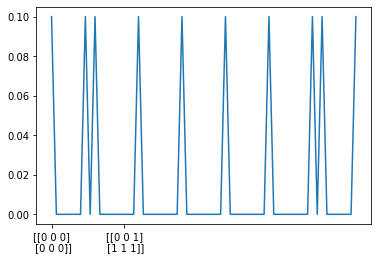

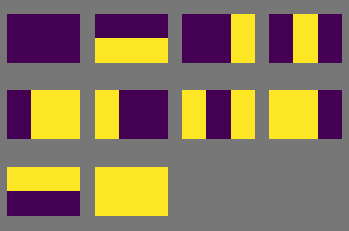

In [5]:
geometry = (2, 3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

# show ticks
basis = binary_basis(geometry)
plt.xticks([0, 2**4-1], [basis[0], basis[2**4-1]])
plt.show()

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (3, 4)
plot_bs(samples, size)

In [6]:
n = 6 # n qubits
n_layers = 2 * n ** 2 # number of layers in variational circuit
if n == 1:
    n_layers = 0
dev = qml.device('default.qubit.tf', wires=n)

2022-01-21 21:09:09.912765: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-21 21:09:09.912796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: metis
2022-01-21 21:09:09.912801: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: metis
2022-01-21 21:09:09.912917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-21 21:09:09.912934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-21 21:09:09.912937: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-21 21:09:09.913251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

In [7]:
def get_target(sample_pos):
    '''
        Prepare target state at the first n qubits.
    '''
    state = np.zeros(2**n)
    state[sample_pos] = 1
    qml.QubitStateVector(state, wires=list(range(n)))

In [8]:
def variational_circuit(n_layers, weights, wires, **kwargs):
    '''
        Template for a variational circuit.
    '''
    pos = 0
    for i in range(len(wires)):
        qml.RX(weights[pos], wires=wires[i])
        qml.RY(weights[pos+1], wires=wires[i])
        qml.RZ(weights[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n_layers):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(weights[pos], wires=wires[i])
            qml.RY(weights[pos+1], wires=wires[i])
            qml.RZ(weights[pos+2], wires=wires[i])
            pos += 3

In [9]:
def variational_qpca(n_layers, variational_params, **kwargs):
    '''
        Perform variational quantum PCA.
    '''
    variational_circuit(n_layers, variational_params, np.arange(n))

In [10]:
@qml.qnode(dev, interface="tf", diff_method="backprop")
def measurement(variational_params, sample_pos=None, n_layers=None, **kwargs):
    '''
        Measure sigma_z for computing PCA loss.
    '''
    get_target(sample_pos)
    variational_qpca(n_layers, variational_params)
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

pj = 1 / 2 ** n / (2 ** n - 1) * 2 ** tf.range(n, dtype=tf.double)
def loss_qpca(sample_pos, n_layers, variational_params, **kwargs):
    '''
        Compute loss for variational quantum PCA, i.e. $Tr(U \rho U^dagger P)$.
    '''
    z = measurement(variational_params, sample_pos, n_layers)
    return  tf.math.reduce_sum((z + 1) * pj)

In [11]:
# initialize parameters
np.random.seed(0)
tf.random.set_seed(0)
# n_target_params = (n_layers + 1) * 3 * m
n_var_params = (n_layers + 1) * 3 * n

# target_params = np.array([0] * n_target_params) + np.random.normal(scale=np.pi, size=(n_target_params,))

eps = np.pi
init_var_params = np.array([0] * n_var_params) + np.random.normal(scale=eps, size=(n_var_params,))
# init_var_params = np.loadtxt('./ckpt.csv', delimiter=',')
var_params = tf.Variable(init_var_params)

# SGD faces barren plateau, Adam is better
# lr = 6 for SGD, 0.1 for Adam
# opt = tf.keras.optimizers.SGD(6)
opt = tf.keras.optimizers.Adam(0.1, decay=0.1)
# opt = tf.keras.optimizers.Adadelta(lr=0.1)

In [12]:
# sigular value decomposition
target_state = np.diag(pl2)
U, S, V = np.linalg.svd(target_state)
print('eigenvalues: ', S[:20])

# calculate theoretical minimum of loss
loss_minimum = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
loss_maximum = np.sum(S * np.arange(len(S))[::-1]) / 2 ** n / (2 ** n - 1) * 2
print('loss minimum: ', loss_minimum)
print('loss maximum: ', loss_maximum)

eigenvalues:  [1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 9.99200722e-18 9.99200722e-18
 9.99200722e-18 9.99200722e-18 9.99200722e-18 9.99200722e-18
 9.99200722e-18 9.99200722e-18 9.99200722e-18 9.99200722e-18]
loss minimum:  0.002232142857142867
loss maximum:  0.02901785714285715


In [13]:
def get_sample(prob):
    return np.random.choice(np.arange(0, 2**n), p=prob)

In [69]:
# train variational quantum PCA
n_step = 50
n_batch = 5

def cost():
    c = 0
    for b in tqdm(range(n_batch), leave=False):
        sample_pos = get_sample(pl2)
        c += loss_qpca(sample_pos, n_layers, var_params) / n_batch
    return c

# cost_list = []
for step in tqdm(range(n_step)):
    opt.minimize(cost, var_params)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        tqdm.write("Step {}: cost = {}, relative excess = {}".format(step, cost_val, (cost_val - loss_minimum) / (loss_minimum)))
        np.savetxt('./ckptBAS.csv', var_params.numpy(), delimiter=',')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 0: cost = 0.002500525317051929, relative excess = 0.12023534203925923


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 5: cost = 0.002595515029207167, relative excess = 0.16279073308480574


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 10: cost = 0.0021338278366589943, relative excess = -0.04404512917677478


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 15: cost = 0.0026404829752033326, relative excess = 0.18293637289108777


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 20: cost = 0.0025303923991642856, relative excess = 0.13361579482559496


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 25: cost = 0.00305777488878807, relative excess = 0.36988315017704937


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 30: cost = 0.002161737926181124, relative excess = -0.031541409070860754


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Step 35: cost = 0.0023191346483498777, relative excess = 0.03897232246074064


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

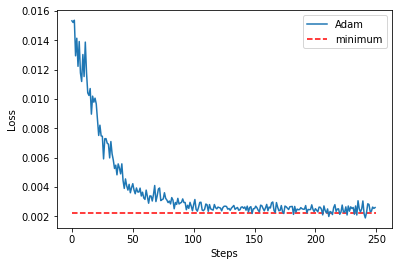

In [70]:
# plot loss
# plt.plot(cost_list_sgd[:400], label='SGD')
plt.plot(cost_list, label='Adam')
# plt.hlines(loss_maximum, 0, n_step, colors='r', linestyles='--', label='maximum')
plt.hlines(loss_minimum, 0, len(cost_list), colors='r', linestyles='--', label='minimum')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
dev_gen = qml.device('default.mixed', wires=n)
@qml.qnode(dev_gen, interface=None)
def get_pca_state(n_layers, variational_params):
    '''
        Generate state via qPCA^dagger.
    '''
    qml.QubitDensityMatrix(np.diag(pl2), wires=list(range(n)))
    variational_qpca(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

eigenvalues:  [1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 9.99200722e-18 9.99200722e-18
 9.99200722e-18 9.99200722e-18 9.99200722e-18 9.99200722e-18
 9.99200722e-18 9.99200722e-18 9.99200722e-18 9.99200722e-18]
pca results:  [0.09905563 0.09905284 0.0988671  0.09879959 0.0979166  0.09764807
 0.09646599 0.0938546  0.08863891 0.07355176 0.02990271 0.00384767
 0.00379607 0.00370253 0.00258521 0.00222486 0.00191739 0.00091406
 0.00079252 0.00049167]
eigenvalue mse:  2.8884109823671804e-05


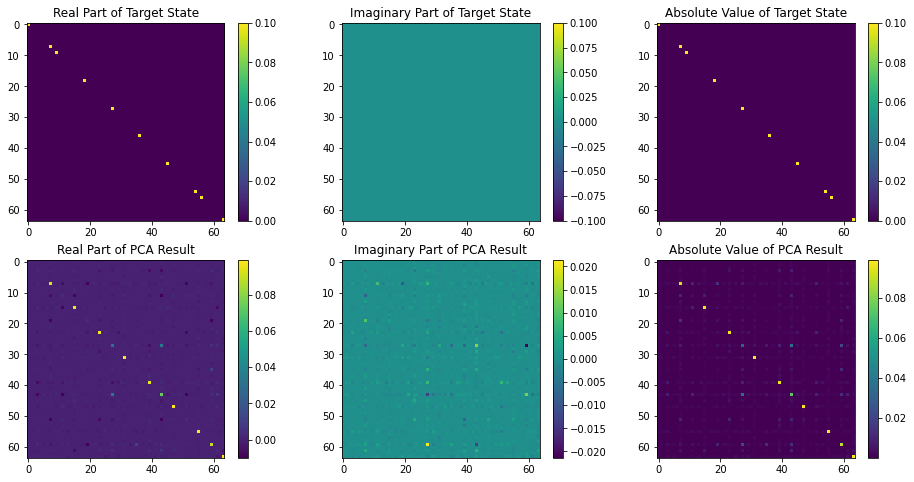

In [72]:
print('eigenvalues: ', S[:20])

# extract and compute eigenvalues from qpca
pca_state = get_pca_state(n_layers, var_params)
pca_eigen, order = np.unique(-np.abs(np.diag(pca_state)), return_inverse=True)
pca_eigen = -pca_eigen

print('pca results: ', pca_eigen[:20])
print('eigenvalue mse: ', np.mean((pca_eigen - S) ** 2))

# plot target and pca state
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

plt.show()

In [73]:
dev_gen = qml.device('default.mixed', wires=n)
@qml.qnode(dev_gen, interface=None)
def generator(pca_eigs, n_layers, variational_params):
    '''
        Generate state via qPCA^dagger.
    '''
    qml.QubitDensityMatrix(np.diag(pca_eigs), wires=list(range(n)))
    qml.adjoint(variational_qpca)(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

mse of generated state:  5.745842994615682e-05


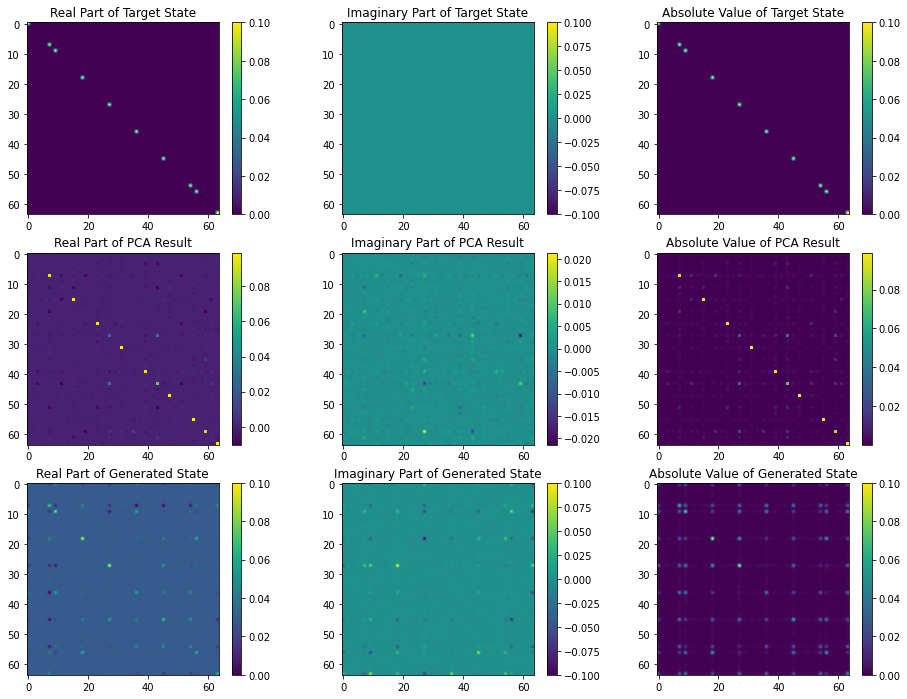

In [74]:
# truncate eigenvalues
n_trunc = 3
trunc_pca_eigs = np.pad(pca_eigen[:n_trunc]/np.sum(pca_eigen[:n_trunc]), (0, 2 ** n - n_trunc), 'constant')[order]
gen_state = generator(trunc_pca_eigs, n_layers, var_params)

# print('real eigs sorted:\n', S)
# print('pca eigs sorted:\n', pca_eigen)
# print('pca eigs:\n', np.diag(pca_state))
# print('trunc pca eigs:\n', trunc_pca_eigs)

print('mse of generated state: ', np.mean(np.abs(gen_state - target_state)**2))

fig, ax = plt.subplots(3, 3, figsize=(16, 12))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

im_gen_real = ax[2][0].imshow(np.real(gen_state))
ax[2][0].set_title('Real Part of Generated State')
plt.colorbar(im_target_real, ax=ax[2][0])
im_gen_imag = ax[2][1].imshow(np.imag(gen_state))
ax[2][1].set_title('Imaginary Part of Generated State')
plt.colorbar(im_target_imag, ax=ax[2][1])
im_gen_abs = ax[2][2].imshow(np.abs(gen_state))
ax[2][2].set_title('Absolute Value of Generated State')
plt.colorbar(im_target_abs, ax=ax[2][2])

plt.show()

In [90]:
dev_sam = qml.device('qulacs.simulator', wires=n, shots=1000000)
@qml.qnode(dev_sam, interface=None)
def generate_samples(pca_eigs, n_layers, variational_params):
    '''
        Generate state via qPCA^dagger.
    '''
    state = np.zeros(2**n)
    sample_pos = np.random.choice(np.arange(0, 2**n), p=pca_eigs)
    state[sample_pos] = 1
    qml.QubitStateVector(state, wires=list(range(n)))
    qml.adjoint(variational_qpca)(n_layers, variational_params)
    return qml.sample()

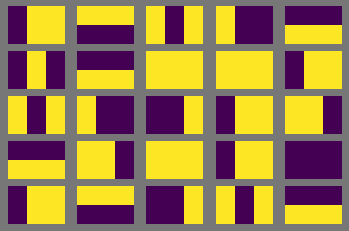

In [99]:
gen_samples = generate_samples(trunc_pca_eigs, n_layers, var_params)
plot_bs(gen_samples.reshape(-1, 2, 3), (5, 5))

In [100]:
np.average(is_bs(gen_samples.reshape(-1, 2, 3)))

0.990555